In [17]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import scikitplot as skplt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from sklearn.model_selection import KFold

# Carregando base de dados  pré-processada

In [18]:
dataset = pd.read_csv("../../Database/dataBaseWithNER.csv")
dataset = dataset.drop(columns=["Unnamed: 0"])
dataset = dataset.dropna()
targets = np.array(dataset["target"].array)

dataset

,email,target
0,sandoval vcsc brand new stock attention voca...,1
1,tired spending extra purchase medication wan...,1
2,request start providing datee status report w...,0
3,got stuart,0
4,want money home tired working welcome future...,1
...,...,...
26671,old fish young flesh feed men best win lose m...,1
26672,hello vince thank forwarding message hope r...,0
26673,customer better selection dr prescribed remed...,1
26674,working company image start visual identity ...,1


In [19]:
emailsText = []
for email in dataset["email"]:
    emailsText.append(email)

del dataset

,email,target
0,note personn pleased announce effective datee...,0
1,dear orgg japan team disregard datee notice ...,0
2,save medl correct cation percentt pharmsho sp...,1
3,forwarded personn datee ...,0
4,hi genierc gpee viarga caiils available oin...,1
...,...,...
6664,searching place buy med online recently pl...,1
6665,approval process initiated datee meeting event...,0
6666,credit mess want perfect credit nice easily...,1
6667,tue datee cardinall cardinall dear sir hop...,1


# Representação vetorial Bag of Words

In [24]:
vectorizer = CountVectorizer(max_features=2100)
X = vectorizer.fit_transform(emailsText)

bag = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())

del emailsText
del X

bag

E:\DevPack\anaconda3\envs\data_science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,ability,able,absolutely,accept,acceptance,accepted,access,according,account,...,xanax,xl,xp,yahoo,year,yes,yield,yo,young,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26668,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
26669,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
bag = np.array(bag)
bag

E:\DevPack\anaconda3\envs\data_science\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ability,able,absolutely,abuse,accept,acceptance,accepted,access,according,account,...,www,wysak,xl,xp,yahoo,year,yes,yield,young,zone
0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6663,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6665,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6666,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Visualização de dados com TSNE

In [26]:
# model = TSNE(n_components=2, random_state=0)
# #model = PCA(n_components=50, svd_solver='full')
# array_red = model.fit_transform(bag)
#
# df_tsne = pd.DataFrame(array_red)
#
# df_tsne['Target'] = target
# df_tsne_c1 = df_tsne[df_tsne['Target'] == 0]
#
# df_tsne_c2 = df_tsne[df_tsne['Target'] == 1]
#
# plt.scatter(df_tsne_c1[0].array,df_tsne_c1[1].array,marker='o',color='blue')
#
# plt.scatter(df_tsne_c2[0].array,df_tsne_c2[1].array,marker='o',color='red')
#
# plt.title('Dados')
# plt.xlabel('x')
# plt.ylabel('y')
#
# plt.show()

# Validação

In [27]:
foldsAccuracy = []
foldLosses = []

In [28]:

kfold = KFold(n_splits=4, shuffle=True)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [29]:
foldCount = 1
for train, test in kfold.split(bag, targets):
    model = keras.models.Sequential([
        ########## MLP
        keras.layers.Flatten(input_shape=(bag.shape[1],)),
        keras.layers.Dense(1000, activation="relu"),
        keras.layers.Dense(1000, activation="relu"),
        keras.layers.Dense(1000, activation="relu"),

        keras.layers.Dense(len(set(targets)), activation="softmax")
    ])

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    print('****************************************************')
    print(f'Iniciando treinamento da fold: {foldCount}.')

    callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4,mode='min'), tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, restore_best_weights=True)]

    history = model.fit(bag[train], targets[train], epochs=200, callbacks=callbacks, validation_split=0.05)

    scores = model.evaluate(bag[test], targets[test], verbose=0)
    print(f'Score fold {foldCount}: {model.metrics_names[0]} de {scores[0]}; {model.metrics_names[1]} de {scores[1]*100}%')

    foldsAccuracy.append(scores[1] * 100)
    foldLosses.append(scores[0])

    foldCount = foldCount + 1

In [30]:
print('****************************************************')
print('Score de cada fold:')
for i in range(0, len(foldsAccuracy)):
    print('****************************************************')
    print(f'--> Fold {i+1}: Loss: {foldLosses[i]} ; Accuracy: {foldsAccuracy[i]}%')

print('****************************************************')
print('Média de accuracy das folds:')
print(f'--> Accuracy: {np.mean(foldsAccuracy)} (+- {np.std(foldsAccuracy)})')
print(f'--> Loss: {np.mean(foldLosses)}')
print('****************************************************')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2100)              0         
                                                                 
 dense_4 (Dense)             (None, 1000)              2101000   
                                                                 
 dense_5 (Dense)             (None, 300)               300300    
                                                                 
 dense_6 (Dense)             (None, 100)               30100     
                                                                 
 dense_7 (Dense)             (None, 2)                 202       
                                                                 
Total params: 2,431,602
Trainable params: 2,431,602
Non-trainable params: 0
_________________________________________________________________


## VALIDANDO DE FORMA MAIS ELABORADA

209/209 [==============================] - 0s 846us/step


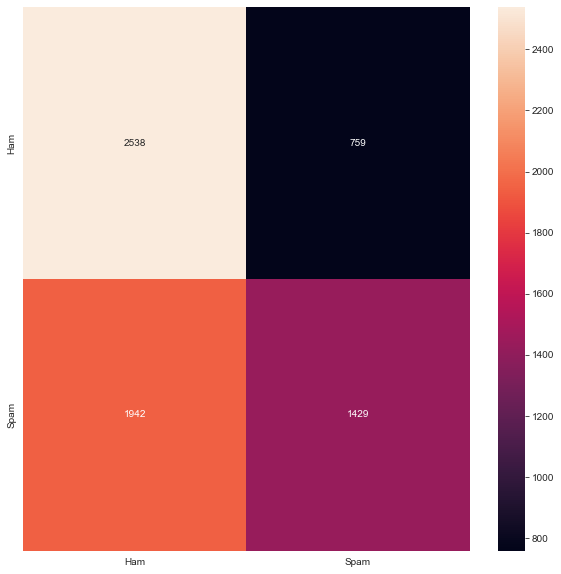

In [35]:
#cm = confusion_matrix(testTarget,np.argmax(model.predict(bagTest.values), axis=-1))
#
#labels = ["Ham", "Spam"]
#
#cm_df = pd.DataFrame(cm, columns=labels)
#
#
#fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(cm_df, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
#
#plt.show()